In [203]:
using Plots
using TensorCrossInterpolation, LinearAlgebra
using QuanticsTCI
using QuanticsGrids
using ITensorMPS
using ITensors
using NDTensors
using TCIITensorConversion
using IterativeSolvers
using LinearMaps
using LinearAlgebra
include("src/differential_mpo.jl")
plotlyjs()

Plots.PlotlyJSBackend()

In [82]:
# simulation parameter
R = 6
max_bond = 20
tol = 1e-5
cutoff = 1e-30
dx = 1 / (2^R-1)
delta_t = 0.1 * 2.0^-(R-1)
nu = 1e-5
penalty_coefficient = 2.5e5

# define grid
grid = DiscretizedGrid{2}(R, (0,0), (1,1); includeendpoint = true)

# define sites
s = siteinds("Qudit", R, dim=4)

6-element Vector{Index{Int64}}:
 (dim=4|id=527|"Qudit,Site,n=1")
 (dim=4|id=219|"Qudit,Site,n=2")
 (dim=4|id=861|"Qudit,Site,n=3")
 (dim=4|id=309|"Qudit,Site,n=4")
 (dim=4|id=16|"Qudit,Site,n=5")
 (dim=4|id=572|"Qudit,Site,n=6")

In [83]:
# initial conditions

x_min = 0.4
x_max = 0.6
h = 1/200

function d_1_func(x, y)
    out = 2 / h^2 * ( (y - x_max) * exp( -(y - x_max)^2 / h^2 ) + (y - x_min) * exp( -(y - x_min)^2 / h^2 ) )
    return out * ( sin(8π * x) + sin(24π * x) + sin(6π * x) ) 
end

function d_2_func(x, y)
    out = π * ( exp( -(y - x_max)^2 / h^2 ) + exp( -(y - x_min)^2 / h^2 ) )
    return out * ( 8*cos(8π * x) + 24*cos(24π * x) + 6*cos(6π * x) ) 
end

function A_func(x, y)
    return sqrt( d_1_func(x,y)^2 + d_2_func(x,y)^2 )
end

A = find_max_on_2D_grid(A_func, R)
u_0 = 1.
delta_var = u_0 / (40 * A)

function J_1_func(y)
    return u_0 / 2 * ( tanh( (y - x_min)/h ) - tanh( (y - x_max)/h ) - 1 )
end

function D_1_func(x, y)
    return delta_var * d_1_func(x, y)
end

function D_2_func(x, y)
    return delta_var * d_2_func(x, y)
end

function u_init_1_func(x, y)
    return J_1_func(y) + D_1_func(x, y)
end

function u_init_2_func(x, y)
    return D_2_func(x, y)
end

u_init_2_func (generic function with 1 method)

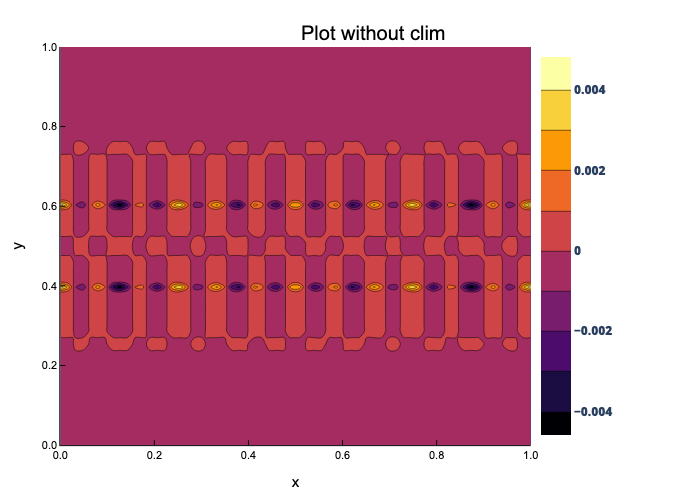

In [84]:
 # build mps with QuanticsTCI
u1q, ranks1, errors1 = quanticscrossinterpolate(Float64, u_init_1_func, grid; maxbonddim=max_bond)
u2q, ranks2, errors2 = quanticscrossinterpolate(Float64, u_init_2_func, grid; maxbonddim=max_bond)

# convert to ITensorMPS format
u1 = deepcopy(ITensorMPS.MPS(TensorTrain(u1q.tci), sites=s))
u2 = deepcopy(ITensorMPS.MPS(TensorTrain(u2q.tci), sites=s))
v1 = deepcopy(u1)
v2 = deepcopy(u2)
a1 = deepcopy(u1)
a2 = deepcopy(u2)
b1 = deepcopy(u1)
b2 = deepcopy(u2)

# build base MPO's
d1x = Diff_1_8_x(dx, s)
d1y = Diff_1_8_y(dx, s)
d2x = Diff_2_8_x(dx, s)
d2y = Diff_2_8_y(dx, s)
dx_dx = apply(d1x, d1x, maxdim=max_bond, cutoff=cutoff)
dy_dy = apply(d1y, d1y, maxdim=max_bond, cutoff=cutoff)
dx_dy = apply(d1x, d1y, maxdim=max_bond, cutoff=cutoff)
del = MPO([delta(s[i], s[i]', s[i]'') for i in 1:length(s)])
plot_mps(u2, R, 6)

In [110]:
center = 1
# orthogonalize mps's
orthogonalize!(v1, R)
orthogonalize!(v2, R)
orthogonalize!(a1, R)
orthogonalize!(a2, R)
orthogonalize!(b1, R)
orthogonalize!(b2, R)
orthogonalize!(v1, center)
orthogonalize!(v2, center)
orthogonalize!(a1, center)
orthogonalize!(a2, center)
orthogonalize!(b1, center)
orthogonalize!(b2, center)

# starting guess for cg
c_vec = get_c_vec(v1, v2, center)

# rhs of equation
beta = make_beta(v1, v2, a1, a2, b1, b2, center, delta_t, nu, d1x, d1y, d2x, d2y, del, max_bond, cutoff)

# linear operator
function A_function(c_vec)
    H_c = apply_H(c_vec, v1, v2, dx_dx, dy_dy, dx_dy, center, max_bond, cutoff)
    return c_vec - penalty_coefficient * delta_t^2 * H_c
end
d = prod(size(v1[center])) + prod(size(v2[center]))
A = FunctionMap{Float64,false}(A_function, d)

32×32 FunctionMap{Float64,false}(A_function; issymmetric=false, ishermitian=false, isposdef=false)

In [78]:
# c_vec = get_c_vec(v1, v2, center) # restart iteration
error = norm(A(c_vec) - beta) / sqrt(length(c_vec))
history = cg!(c_vec, A, beta, abstol=1e-6, verbose=false, maxiter=100, log=true)[2]
println(history)
new_error = norm(A(c_vec) - beta) / sqrt(length(c_vec))
println("Old error: $(error)\nNew error: $(new_error)\nRelative improvement: $(new_error/error)")

Converged after 13 iterations.
Old error: 0.0012710510385256044
New error: 5.7323382898889936e-5
Relative improvement: 0.04509919834956745


In [68]:
v1, v2 = insert_c_vec(c_vec, v1, v2, center)
println("Done!")

Done!


In [111]:
A_mat = Matrix(A)
display(eigvals(A_mat))
diff = abs.(A_mat - transpose(A_mat))
println("Max difference: $(maximum(diff))")
println("Mean diff: $(sum(diff) / length(diff))")
display(A_mat)

32-element Vector{Float64}:
     1.0714176310503947
     1.071417631050731
     1.1136924432922402
     1.1136924432937292
  1020.5213247401989
  1020.5213253161805
  1041.1927997095263
  1041.1928001789452
  2018.3354034166464
  2018.3354034166482
     ⋮
 13192.308396599481
 13192.464761087005
 13192.464761087007
 13192.465467665319
 13192.465467665323
 13193.450070115932
 13193.450071324449
 13194.161418661768
 13194.16142103151

Max difference: 0.004697303629870753
Mean diff: 0.00015109075555474794


32×32 Matrix{Float64}:
  523.202        -522.098        …      2.83999e-14      3.19556e-14
 -522.098         523.202              -7.69735e-15      1.74882e-14
   -2.57414e-29     0.0               -58.3874          58.1744
   -1.33889e-29     0.0                58.1744         -58.3874
   -0.0221687       0.0465639           6.66187e-15      7.49597e-15
    0.0465639      -0.0221687    …     -1.8056e-15       4.10227e-15
    0.0             0.0               -13.6962          13.6462
    0.0             0.0                13.6462         -13.6962
  -28.8261         34.5606              1.07123e-14     -6.19701e-15
   34.5606        -28.8261              1.7651e-16       1.16803e-14
    ⋮                            ⋱      ⋮            
    1.03908e-13    -2.87512e-14         0.0             -4.23435e-12
   -1.2336e-15      3.98764e-15        -1.12035e-12      6.41938e-29
    1.95605e-14     8.12543e-15  …     -1.68076e-28     -4.51341e-13
    2.68016e-14    -1.43144e-14         2.1033

In [204]:
v1 = deepcopy(u1)
v2 = deepcopy(u2)
display(v1)
display(v2)

MPS
[1] ((dim=4|id=527|"Qudit,Site,n=1"), (dim=4|id=352|"l=1,link"))
[2] ((dim=4|id=352|"l=1,link"), (dim=4|id=219|"Qudit,Site,n=2"), (dim=9|id=661|"l=2,link"))
[3] ((dim=9|id=661|"l=2,link"), (dim=4|id=861|"Qudit,Site,n=3"), (dim=17|id=414|"l=3,link"))
[4] ((dim=17|id=414|"l=3,link"), (dim=4|id=309|"Qudit,Site,n=4"), (dim=10|id=128|"l=4,link"))
[5] ((dim=10|id=128|"l=4,link"), (dim=4|id=16|"Qudit,Site,n=5"), (dim=4|id=829|"l=5,link"))
[6] ((dim=4|id=829|"l=5,link"), (dim=4|id=572|"Qudit,Site,n=6"))


MPS
[1] ((dim=4|id=527|"Qudit,Site,n=1"), (dim=4|id=395|"l=1,link"))
[2] ((dim=4|id=395|"l=1,link"), (dim=4|id=219|"Qudit,Site,n=2"), (dim=8|id=887|"l=2,link"))
[3] ((dim=8|id=887|"l=2,link"), (dim=4|id=861|"Qudit,Site,n=3"), (dim=12|id=957|"l=3,link"))
[4] ((dim=12|id=957|"l=3,link"), (dim=4|id=309|"Qudit,Site,n=4"), (dim=8|id=35|"l=4,link"))
[5] ((dim=8|id=35|"l=4,link"), (dim=4|id=16|"Qudit,Site,n=5"), (dim=4|id=441|"l=5,link"))
[6] ((dim=4|id=441|"l=5,link"), (dim=4|id=572|"Qudit,Site,n=6"))


In [207]:
center = 4
orthogonalize!(v1, center)
orthogonalize!(v2, center)
function B_function(c_vec)
    v1_p, v2_p = insert_c_vec(c_vec, v1, v2, center)
    out_1 = contract_except_center(v1_p, v1_p, center)
    out_2 = contract_except_center(v2_p, v2_p, center)
    display(maximum(abs.(array(out_1) - array(v1_p[center]))))
    display(maximum(abs.(array(out_2) - array(v2_p[center]))))
    out = vcat(vec(array(out_1)), vec(array(dag(out_2)))) # combine into 1d-vector
    out[abs.(out) .< cutoff] .= 0 
    return out
end
d = prod(size(v1[center])) + prod(size(v2[center]))
B = FunctionMap{Float64,false}(B_function, d)

1064×1064 FunctionMap{Float64,false}(B_function; issymmetric=false, ishermitian=false, isposdef=false)

In [160]:
B_mat = Matrix(B)
display(eigvals(B_mat))
diff = abs.(B_mat - transpose(B_mat))
println("Max difference: $(maximum(diff))")
println("Max difference index: $(argmax(diff))")
println("Mean diff: $(sum(diff) / length(diff))")
display(B_mat)
println(B_mat[581,397])
println(B_mat[397,581])

288-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

Max difference: 0.0
Max difference index: CartesianIndex(1, 1)
Mean diff: 0.0


288×288 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …

BoundsError: BoundsError: attempt to access 288×288 Matrix{Float64} at index [581, 397]

In [208]:
c_vec = get_c_vec(v1, v2, center)
B(c_vec)

DimensionMismatch: DimensionMismatch: a has size (4, 17, 10), b has size (4, 10, 17), mismatch at dim 2

In [100]:
center = 4
test_1 = orthogonalize(v1, center)
test_2 = orthogonalize(v2, center)
display(v1)
display(test_1)

MPS
[1] ((dim=4|id=527|"Qudit,Site,n=1"), (dim=4|id=918|"l=1,link"))
[2] ((dim=4|id=219|"Qudit,Site,n=2"), (dim=4|id=918|"l=1,link"), (dim=9|id=516|"l=2,link"))
[3] ((dim=4|id=861|"Qudit,Site,n=3"), (dim=9|id=516|"l=2,link"), (dim=17|id=513|"l=3,link"))
[4] ((dim=4|id=309|"Qudit,Site,n=4"), (dim=10|id=994|"l=4,link"), (dim=17|id=513|"l=3,link"))
[5] ((dim=4|id=16|"Qudit,Site,n=5"), (dim=4|id=884|"l=5,link"), (dim=10|id=994|"l=4,link"))
[6] ((dim=4|id=572|"Qudit,Site,n=6"), (dim=4|id=884|"l=5,link"))


MPS
[1] ((dim=4|id=527|"Qudit,Site,n=1"), (dim=4|id=918|"l=1,link"))
[2] ((dim=4|id=219|"Qudit,Site,n=2"), (dim=4|id=918|"l=1,link"), (dim=9|id=516|"l=2,link"))
[3] ((dim=4|id=861|"Qudit,Site,n=3"), (dim=9|id=516|"l=2,link"), (dim=17|id=523|"l=3,link"))
[4] ((dim=4|id=309|"Qudit,Site,n=4"), (dim=10|id=994|"l=4,link"), (dim=17|id=523|"l=3,link"))
[5] ((dim=4|id=16|"Qudit,Site,n=5"), (dim=4|id=884|"l=5,link"), (dim=10|id=994|"l=4,link"))
[6] ((dim=4|id=572|"Qudit,Site,n=6"), (dim=4|id=884|"l=5,link"))


In [ ]:
# solve system
info = true
max_iter = 10
error = norm(A(c_vec) - beta) / length(c_vec)

for i in 1:max_iter
    cg!(c_vec, A, beta, abstol=0, reltol=tol, verbose=false, maxiter=100, log=false)
    error_new = norm(A(c_vec) - beta) / length(c_vec)

    if info
        println("Step $(i), new error = $(error_new)")
    end

    if error_new > error
        println("Failed at step $(i), error: $(error_new)")
        break
    else
        error = error_new
    end

    if error < tol
        println("Converged at step $(i), error: $(error_new)")
        break
    end
end

v1, v2 = insert_c_vec(c_vec, v1, v2, center)